In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as f
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
dataset = MNIST(root='data/',download=True,transform=ToTensor())

In [3]:
len(dataset)

60000

label: 5


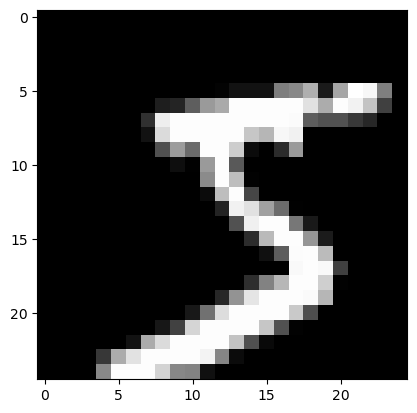

In [4]:
image_tensor,label = dataset[0]
plt.imshow(image_tensor[0,0:25,0:25],cmap='gray')
print('label:',label)

In [5]:
def split_indices(n,val_pct):
    #determine size of validation set
    n_val = int(val_pct*n)
    #create a random permutation of 0 to n-1
    idx = np.random.permutation(n)
    #pick first n_val indices for validation set
    return idx[n_val:],idx[:n_val]

In [6]:
train_indices,val_indices = split_indices(len(dataset), val_pct=0.2)

In [7]:
print(len(train_indices),len(val_indices))
print('sample val_indices:',val_indices[:20])

48000 12000
sample val_indices: [50845 54788 11316 48791 26382 38903 43567 33525 33434  9314  3445 17879
 53695 34267 46021 53414 53392 57537 10332 55283]


In [8]:
batch_size = 100
#define train_sampler and train_loader

train_sampler =SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset,batch_size,sampler=train_sampler)

#validation_sampler and validation_loader

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset,batch_size,sampler=val_sampler)

In [9]:
input_size = 28*28
num_classes = 10
#logistic regression model

model = nn.Linear(input_size,num_classes)

In [10]:
for xb,yb in train_loader:
    print(xb.shape)
    break

torch.Size([100, 1, 28, 28])


In [11]:
#we are using an image size of 100 by 84 so we use the reshape or view method to convert as follow
#xb = xb.reshape(100,784), where 100 is the batch number,but we cannot change the batch size hence we do the following instead
#xb = xb.view(xb.size(0)),784

In [12]:
#to improve upon the logistic  regression,we will create a neural network with one hidden layer
#--instead of using a single nn.linear object to transform a batch of inputs(pixel intensities) into a batch of outputs(class
#probabilities),we will use two nn.linear objects.Each is called a layer in the neural network.
#--the first layer,called the hidden layer will transform the input matrix of shape (batch_size x 784) 
#into an intermediate output matrix of shape (batch_size x hidden_size),
#where hidden size is a preconfigured parameter(eg,32 or 64)
#--the intermediate outputs are then passed into a non linear activation function,which operates on individual
#elements of the output matrix
#--the result of the activation function,which is also of size (batch_size x hidden_size),is passed into the second  layer
#also known as the output layer,which transforms it into a matrix of size(batch_size x 10),
#identical to the output of the logistic regression
#the activation function we will use here is called the ReLU(Rectified Linear Unit) with formula
#relu(x) = max(0,x).That is if an element is negative,we replace it by 0,otherwise we leave it unchanged.
#


In [13]:
class MnistModel(nn.Module):
    #feedfoward neural network with one hidden layer
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        #hidden layer
        self.linear = nn.Linear(in_size,hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size,out_size)
    def forward(self,xb):
            #flatten the image tensor using the view(ensure that we are using the same block of memory) or reshape method
            xb = xb.view(xb.size(0),-1)
            #from above,784(28x28) is the image size we must use but it is only so in this case but
            #might differ with different images so we use (-1) to allow pytorch to calculate it for us 
            #get intermediate output using hidden layer
            out = self.linear(xb)
            #apply activation function
            out = f.relu(out)
            #get predictions using output layer
            out = self.linear2(out)
            return out
        

In [14]:
input_size = 784
num_classes = 10

In [15]:
#we will create a model with a hidden layer of 32 activations

In [16]:
model = MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [17]:
#lets take a look at the models parameters,we  expect to see one weight and bias matrix for each of the network layers

In [18]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [19]:
#lets try and generate some outputs using our model, we will take the first batch of 100 images from 
#our dataset,and pass them into our model

In [20]:
for images,labels in train_loader:
    outputs = model(images)
    loss = f.cross_entropy(outputs,labels)
    print('loss:',loss.item())
    print('output.shape:',outputs.shape)
    print('sample outputs:',outputs[:2].shape)
    break

loss: 2.3229575157165527
output.shape: torch.Size([100, 10])
sample outputs: torch.Size([2, 10])


In [21]:
probs = f.softmax(outputs,dim=1)

In [22]:
max_probs,preds = torch.max(probs,dim=1)

In [23]:
print(preds)

tensor([2, 2, 3, 5, 8, 8, 5, 5, 2, 2, 5, 8, 5, 3, 5, 2, 3, 2, 3, 3, 5, 1, 5, 2,
        2, 3, 3, 3, 3, 5, 5, 3, 5, 5, 5, 5, 8, 5, 3, 3, 3, 2, 8, 5, 3, 2, 3, 2,
        5, 8, 5, 5, 6, 5, 3, 3, 2, 5, 5, 2, 5, 5, 3, 5, 3, 6, 5, 2, 5, 5, 2, 2,
        5, 5, 5, 5, 5, 3, 5, 5, 3, 3, 5, 3, 3, 3, 8, 5, 5, 3, 3, 3, 5, 2, 5, 2,
        8, 2, 5, 2])


In [24]:
labels==preds

tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,  True,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [25]:
#USING GPU's 

#as the size of our model and datasets increase, we need to use GPU's to train our models within a reasonable amount of time
#GPU's contain hundreds of cores that are optimized for performing expensive matrix operations on floating
#point numbers in a short period of time,which makes them ideal for  training deep nueral networks with many layers.
#you can use GPU's for free on kaggle kernels or googgle colab,or rent GPU powered machines 
#on services like Google Cloud Platforms,Amazon Web services or paperspace
#we can check if GPU is available and also if the required NVIDIA CUDA + drivers are available usong (torch.cuda.is_available())


In [26]:
torch.cuda.is_available()

False

In [27]:
#lets define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isnt

In [28]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [29]:
device = get_default_device()
device

device(type='cpu')

In [30]:
#lets define a method that can move data and model to a chosen device
#we send data or models to GPU's, the GPU trains the model in a shortest time and returns the model

In [31]:
def to_device(data,device):
    #move tensor to chosen device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [32]:
for images,labels in train_loader:
    print(images.shape)
    images = to_device(images,device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cpu


In [33]:
#finally we define a DeviceDataLoader class to wrap loaders and move move data to the selected device
#as the batches are accessed.We dont need to extend an existing class to to create a pytorch pytorch dataloader.
#All we need is an __iter__() function to retrieve batches of data,a __len__ method to get the number of batches
#data is moved to the device at the exact point when the data is being passed ito the model to save memory

In [34]:
class DeviceLoader():
    #wrap a dataloader to move data to a device
    def __init__(self,dataloader,device):
        self.dataloader=dataloader
        self.device=device
    def __iter__(self):
        #yield a batch of data after moving it to device
        for b in self.dataloader:
            #yield pauses the execution of an instance of the function and executes the function on the next call
            yield to_device(b,self.device)
    def __len__(self):
        #return number of batches
        return len(self.dataloader)
        
            

In [35]:
#we can now wrap our dataloaders using our DeviceDataLoader

In [36]:
train_loader = DeviceLoader(train_loader,device)
val_loader = DeviceLoader(val_loader,device)

In [37]:
for xb,yb in train_loader:
    print('yb:',yb)
    break

yb: tensor([6, 0, 3, 0, 1, 1, 9, 6, 1, 4, 0, 1, 6, 3, 1, 7, 3, 7, 6, 1, 0, 0, 7, 6,
        7, 8, 9, 6, 1, 6, 2, 4, 3, 9, 8, 6, 4, 5, 7, 2, 9, 9, 1, 8, 9, 5, 7, 1,
        9, 5, 0, 1, 6, 8, 9, 0, 3, 6, 3, 9, 0, 3, 2, 9, 8, 1, 9, 7, 7, 7, 5, 9,
        8, 3, 4, 7, 2, 8, 8, 5, 8, 8, 4, 6, 6, 8, 7, 7, 6, 0, 7, 2, 1, 1, 6, 6,
        8, 8, 1, 0])


In [38]:
#MODEL TRAINING

In [39]:
#repeat for given num of epochs
def loss_batch(model,loss_fn,xb,yb,opt=None,metric=None):

        preds = model(xb)
        loss = loss_fn(preds,yb)
        if opt is not None:
            #compute gradient of loss
            loss.backward()
            #update predictions using gradients
            opt.step()
            #reset gradients to zero
            opt.zero_grad()
            metric_result = None
        if metric is not None:
                #compute metric
                metric_result = metric(preds,yb)
                
        return loss.item(),len(xb),metric_result
                
            
    
            
                  
    

In [41]:
def evaluate(model,loss_fn,valid_dl,metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
        #separate losses,counts and metrics
        losses,nums,metrics = zip(*results)
        #total size of the dataset
        total = np.sum(nums)
        #average loss across batches
        avg_loss = np.sum(np.multiply(losses,nums))/total
        avg_metric = None
    if metric is not None:
        #average of metric across batches
        avg_metric = np.sum(np.multiply(metrics,nums))/total
    return avg_loss,total,avg_metric
        

In [40]:
def fit(epochs,lr,model,loss_fn,train_dl,valid_dl,metric=None,opt_fn=None):
    loss,metrics = [],[]
    #instantiate the optimizer
    if opt_fn is None:
        opt_fn = torch.optim.SGD
        opt=opt_fn(model.parameters(),lr=lr)
    for epoch in range(epochs):
        #training of training dataset
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model,loss_fn,xb,yb,opt,metric=accuracy)
            #evaluation of evaluation dataset
            result = evaluate(model,loss_fn,valid_dl,metric)
            avg_loss,total,avg_metric = result
            #record the loss and metrics
            losses.append(val_loss)
            metrics.append(val_metric)
            #print progress
    if metric is None:
        print('Epoch[{}/{}],Loss:{:.4f}'.format(epoch+1,epochs,val_loss))
    else:
            print('Epoch[{}/{}],Loss:{:.4f},{}:{:.4f}'.format(epoch+1,epochs,val_loss,metric.__name__,val_loss))
            
        
              
            
        
        
        

In [42]:
def accuracy(outputs,labels):
    max_probs,preds = torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [43]:
model = MnistModel(input_size,hidden_size=32,out_size=num_classes)
#we use the to_device method to move the model's parameters to thhe right device
to_device(model,device)

MnistModel(
  (linear): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [46]:
#lets see how the model performs on validation set with the initial set of weight and biases
val_loss,total,val_acc = evaluate(model,f.cross_entropy,val_loader,metric=accuracy)
print('loss:{:.4f},accuracy:{:.4f}'.format(val_loss,val_acc))

loss:2.3182,accuracy:0.1179


In [ ]:
#the accuracy is around 10% which is what one might expect from a randomly initialized model(since it has a 1 in 10 chances 
#of getting a label right by guessing randomly)
#we now train the model for 5 epoch and see the results

In [ ]:
losses1,metrics1 = fit(5,0.5,model,f.cross_entropy,train_loader,val_loader,accuracy)

In [ ]:
#from te result above,we have already reached 96% accuracy which is way better than what we had in 
#our logistic regression model.To increse the accuracy further, we can